#Assignment -3
#Sharmila Gowri Velugula - ku3936

#**3B) Seq2Seq Language Translation model for English - Marathi : Word Level**

Import Marathi text file.[mar.txt]

#Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np

#Load the Dataset

In [2]:
with open('mar.txt','r') as f:
  data = f.read()

In [3]:
len(data)

5431289

#Data Cleaning

Here we split each line of the raw data text and storing it into the list named data_list. After that separated all the English and Marathi sentences and stored them into english_word and marathi_word list respectively and in the end, I have printed the total number of English sentences and Marathi sentences.


In [4]:
data_list = data.split('\n')
data_list = data_list[:38695]
len(data_list)

38695

In [5]:
english_word = []
marathi_word = []
cleaned_data_list = []
for word in data_list:
  english_word.append(word.split('\t')[:-1][0])
  marathi_word.append(word.split('\t')[:-1][1])

In [6]:
len(english_word), len(marathi_word)

(38695, 38695)

After that,created a pandas DataFrame with two columns named English and Marathi and saved it as a CSV file.

In [7]:
language_df = pd.DataFrame(columns=['English','Marathi'])
language_df['English'] = english_word
language_df['Marathi'] = marathi_word
language_df.to_csv('language_df.csv', index=False)
language_df = pd.read_csv('language_df.csv')

In [8]:
language_df.head()

,English,Marathi
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [9]:
language_df.tail()

,English,Marathi
38690,There were few students left in the classroom.,वर्गात काहीच विद्यार्थी राहिले होते.
38691,There were more than fifty girls at the party.,पार्टीत पन्नासपेक्षा जास्त मुली होत्या.
38692,These factories are polluting the environment.,हे कारखाने पर्यावरणाला प्रदूषित करताहेत.
38693,They want to participate in the Olympic Games.,त्यांना ऑलिंपिक खेळांमध्ये सहभागी व्हायचं आहे.
38694,They wanted to live in peace with the Indians.,त्यांना भारतीयांबरोबर शांतीने राहायचं होतं.


#Text Cleaning

Text preprocessing which includes lowercase the text, removing punctuation, removing digits, and whitespace.

In [10]:
english_text = language_df['English'].values
marathi_text = language_df['Marathi'].values

In [11]:
len(english_text), len(marathi_text)

(38695, 38695)

In [12]:
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

In [13]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

In [14]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

In [15]:
# removing the digits from english sentances
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [16]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

###Append Start and End to the sentences

In [17]:
# Putting the start and end words in the marathi sentances
marathi_text_ = ["start " + x + " end" for x in marathi_text_]

In [18]:
len(marathi_text_),len(english_text)

(38695, 38695)

In [19]:
marathi_text_[0], english_text_[0]

('start जा end', 'go')

#Train/Test Data Split

In [20]:
X = english_text_
Y = marathi_text_

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(34825, 34825, 3870, 3870)

In [22]:
X[0], Y[0]

('go', 'start जा end')

In seq2seq model,the input sequence to be of same length. So we calculate the length of each sentence in both English and Marathi and then we take the max length i.e the longest sentence in both English and Marathi. Thus we have two max_length one for English sentence and another is for Marathi sentence.

In [23]:
# preparing data for the word embedding
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_lenght_marathi = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_lenght_marathi_test = Max_length(y_test)

Since machines understand numbers only and not the text we need to convert the input text sequence into number and one such way is to index the words of the sentences. We can do this indexing using the “Tokenizer” method of Keras we also need to take the vocabulary size of both English and Marathi corpus which is required when we create the input data for the model training.

In [24]:
def tokenizer_(text_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  return tokenizer

tokenizer_input = tokenizer_(X_train)
vocab_size_input = len(tokenizer_input.word_index) + 1
tokenizer_target = tokenizer_(y_train)
vocab_size_target = len(tokenizer_target.word_index) + 1



In [25]:
with open('tokenizer_input.pkl','wb') as f:
  pkl.dump(tokenizer_input,f)

with open('tokenizer_target.pkl','wb') as f:
  pkl.dump(tokenizer_target,f)
pkl.dump(tokenizer_input, open('tokenizer_input.pkl', 'wb'))
pkl.dump(tokenizer_target, open('tokenizer_target.pkl', 'wb'))

In [26]:
vocab_size_input,vocab_size_target

(5010, 11812)

In [27]:
def generator_batch(X= X_train,Y=y_train, batch_size=128):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_data_input = np.zeros((batch_size,max_length_english),dtype='float32') #metrix of batch_size*max_length_english
      decoder_data_input = np.zeros((batch_size,max_lenght_marathi),dtype='float32') #metrix of batch_size*max_length_marathi
      decoder_target_input = np.zeros((batch_size,max_lenght_marathi,vocab_size_target),dtype='float32') # 3d array one hot encoder decoder target data
      for i, (input_text,target_text) in enumerate(zip(X[j:j+batch_size],Y[j:j+batch_size])):
        for t, word in enumerate(input_text.split()):
          encoder_data_input[i,t] = tokenizer_input.word_index[word] # Here we are storing the encoder 
                                                                     #seq in row here padding is done automaticaly as 
                                                                     #we have defined col as max_lenght
        for t, word in enumerate(target_text.split()):
          # if word == 'START_':
          #   word = 'start'
          # elif word == 'END_':
          #   word = 'end'
          decoder_data_input[i,t] = tokenizer_target.word_index[word] # same for the decoder sequence
          if t>0:
            decoder_target_input[i,t-1,tokenizer_target.word_index[word]] = 1 #target is one timestep ahead of decoder input because it does not have 'start tag'
      # print(encoder_data_input.shape())
      yield ([encoder_data_input,decoder_data_input],decoder_target_input)

The reason for appending “start” and “end” to the decoder input is, “start” tag is used to initiate the decoder to start decoding, and the “end” tag is used to signal decoder to stop decoding process. If we do not use this then the decoder will never be able to produce the first word as we know that if we pass the word to the decoder as input it will predict the next word of the sequence and this prediction will never stop as it is not able to know when to stop.

In [28]:
latent_dim = 50
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
emb_layer_encoder = Embedding(vocab_size_input,latent_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(emb_layer_encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
emb_layer_decoder = Embedding(vocab_size_target,latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(emb_layer_decoder, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

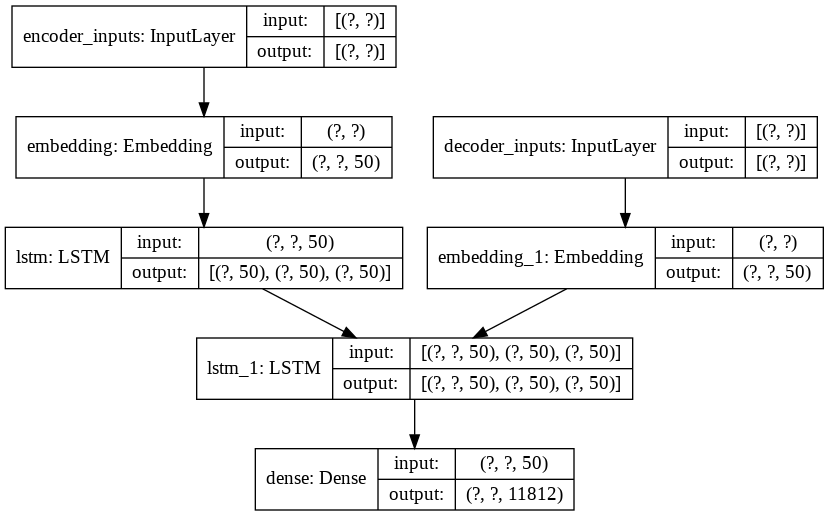

In [30]:
plot_model(model, to_file='train_model.png', show_shapes=True)



Above is the training model.

In [31]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [32]:

model.fit_generator(generator = generator_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
272/272 [==============================] - 256s 942ms/step - loss: 2.4825 - accuracy: 0.1563
Epoch 2/50
272/272 [==============================] - 253s 930ms/step - loss: 2.1375 - accuracy: 0.1822
Epoch 3/50
272/272 [==============================] - 252s 927ms/step - loss: 2.0279 - accuracy: 0.2024
Epoch 4/50
272/272 [==============================] - 253s 931ms/step - loss: 1.9435 - accuracy: 0.2265
Epoch 5/50
272/272 [==============================] - 254s 935ms/step - loss: 1.8658 - accuracy: 0.2443
Epoch 6/50
272/272 [==============================] - 255s 936ms/step - loss: 1.8008 - accuracy: 0.2598
Epoch 7/50
272/272 [==============================] - 255s 939ms/step - loss: 1.7431 - accuracy: 0.2744
Epoch 8/50
272/272 [==============================] - 255s 936ms/step - loss: 1.6895 - accuracy: 0.2898
Epoch 9/50
272/272 [==============================] - 255s 939ms/step - loss: 1.6406 - accur

In [33]:
model_json = model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weight_5.h5")
print("Saved model to disk")

Saved model to disk


In [34]:
# loading the model architecture and asigning the weights
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("model_weight_5.h5")

Will Save the model because we create the inference encoder and decoder to make a prediction later and that model makes use of trained model layers also.

#Inference Setup

In [35]:
latent_dim = 50
#inference encoder
encoder_inputs_inf = model_loaded.input[0] #Trained encoder input layer
encoder_outputs_inf, inf_state_h, inf_state_c = model_loaded.layers[4].output # retoring the encoder lstm output and states
encoder_inf_states = [inf_state_h,inf_state_c]
encoder_model = Model(encoder_inputs_inf,encoder_inf_states)

In [36]:
#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

# # inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)


The encoder inference model is similar to the training model the difference is in the decoder inference model. In encoder-decoder the states of the previous timestamp are pass to the next timestamp hence we need to find a way to preserve the states of the previous timestamp.

Then we create the decoder inference model. To create the decoder model we should define the input layer first. After that, we create the same layers as we have in the training decoder model but the only difference is the initial state of the decoder LSTM is set to be the states of the previous timestamp. Rest of the inference model is similar to the training decoder model.


In [37]:
with open('tokenizer_input.pkl','rb') as f:
  tokenizer_input = pkl.load(f)
with open('tokenizer_target.pkl','rb') as f:
  tokenizer_target = pkl.load(f)
# Creating the reverse mapping to get the word from the index in the sequence
reverse_word_map_input = dict(map(reversed, tokenizer_input.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_target.word_index.items()))


#Prediction

Now we have trained the seq2seq model and created the inference model using the trained model for making prediction so its time to make a prediction

In [38]:

# Code to predct the input sentences translation
def decode_seq(input_seq):
  # print("input_seq=>",input_seq)
  state_values_encoder = encoder_model.predict(input_seq)
  # intialize the target seq with start tag
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tokenizer_target.word_index['start']
  # print("target_seq:=>",target_seq)
  stop_condition = False
  decoder_sentance = ''
  # print("Beforee the while loop")
  while not stop_condition:
    sample_word , decoder_h,decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
    # print("sample_word: =>",sample_word)
    sample_word_index = np.argmax(sample_word[0,-1,:])
    # print("sample_word_index: ",sample_word_index)
    decoder_word = reverse_word_map_target[sample_word_index]
    decoder_sentance += ' '+ decoder_word
    # print("decoded word:=>",decoder_word)
    # print(len(decoder_sentance))
    # print("len(decoder_sentance) > 70: ",len(decoder_sentance) > 70)
    # print('decoder_word == "end"',decoder_word == 'end')
    # print(decoder_word == 'end' or len(decoder_sentance) > 70)
    # stop condition for the while loop
    if (decoder_word == 'end' or 
        len(decoder_sentance) > 70):
        stop_condition = True
        # print("from if condition")
    # target_seq = np.zeros((1,1))
    target_seq[0, 0] = sample_word_index
    # print(target_seq)
    state_values_encoder = [decoder_h,decoder_c]
  return decoder_sentance


The above function returns us the translated sentence, it first encodes the input sentence and gets the state value of the last timestamp of the encoder. Then we have created the metric of single value called “target_seq” which holds the index of the next predicted Marathi word but to start the decoding process we need to pass the first word i.e “start” in this case hence, in the beginning, we are going to store the index of the word “start” into the “target_seq” then since we have to carry out the decoding process till we reach the “end” word. Thus we need to call the decoder inference model in a loop. In the loop, we pass the “target_seq” and the encoder last timestamp “states” as the input to the decoder inference model. The inference decoder_model returns the next word index and the decoder states, after this, we convert that index back to the word and add it to the string variable “decoder_sentance”, then we put the newly generated word index into the “target_seq” and update the “state_value” with the decoder model states this process continues till we get the predicted word as “end”. Hence at the end of the while loop, we get the complete translated sentence. 

In [39]:
for i in range(100):
  sentance = X_test[i]
  original_target = y_test[i]
  input_seq = tokenizer_input.texts_to_sequences([sentance])
  pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
  # print('input_sequence =>',input_seq)
  # print("pad_seq=>",pad_sequence)
  predicted_target = decode_seq(pad_sequence)
  print("Test sentance: ",i+1)
  print("sentance: ",sentance)
  print("origianl translate:",original_target[6:-4])
  print("predicted Translate:",predicted_target[:-4])
  print("=="*50)

Test sentance:  1
sentance:  youve got nothing
origianl translate: तुझ्याकडे काहीच नाहीये
predicted Translate:  तुम्हाला काहीच नाहीये
Test sentance:  2
sentance:  keep an eye on him
origianl translate: त्याच्यावर लक्ष ठेव
predicted Translate:  त्यांना ठेवा
Test sentance:  3
sentance:  we were talking
origianl translate: आपण बोलत होतो
predicted Translate:  आम्ही बोलत होतो
Test sentance:  4
sentance:  she has a picture
origianl translate: त्यांच्याकडे एक चित्र आहे
predicted Translate:  तिच्याकडे एक चित्र आहे
Test sentance:  5
sentance:  i know that all of this is just a game
origianl translate: हा सर्व फक्त एक खेळ आहे हे मला ठाऊक आहे
predicted Translate:  मला ही खूप मोठी असेल तर मी अगदी बर्यापैकी
Test sentance:  6
sentance:  its yours
origianl translate: आपलंच आहे
predicted Translate:  तुझं आहे
Test sentance:  7
sentance:  we just cant find it
origianl translate: आम्हाला सापडतच नाहीये
predicted Translate:  आपल्याला फक्त काहीही माहीत नाही
Test sentance:  8
sentance:  ive made some coffee 